# Churn Prediction

#### What is Churn rate?
* Acording to Investopedia (2020), churn rate, also known as the rate of attrition or costumer churn, is the rate at which customers stop doing business with an entity. It is most commonly expressed as the percentage of service subscribers who discontinue their subscriptions within a given time period. It is also the rate at which employees leave their jobs within a certain period. For a company to expand its clientele, its growth rate (measured by the number of new customers) must exceed its churn rate.


#### The TopBank Company

* A Bank Services Company, with main operations on Europe. 
* Offers financial products such as bank account, investments and insurance.
* Business Model: banking services through physical agencies and online.
* Main Product: bank account without costs, valid for 12 months. After this period, the account must be renovated.Bank account return per client: 15% for clients with estimated income lower than the average;20% for clients with estimated income greater than the average.


#### Challenge
Clients' cancellation rate increased significantly in the last few months.


#### Goal
Reduce clients' churn rate, that is, to avoid that the client cancell the contract and don't renovate it for more 12 months.


#### Deliverables
Deployed model that receives a customers database through API and returns the probability of each client to get into churn.Model's performance and results report with the following topics:
What's the company's current churn rate?How the churn rate varies per month?What's the model's performance to label the clients as churns?What's the company's revenue, if the company avoids the customers to get into churn through the developed model?
Possible measure: discount coupon or other financial incentive.
Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00







* The following project is about predicting customer retention, or churn rate, in a banking service company. The company is active in europeian countries and offers financial products, from banking accounts to investment and insurance.

* The main product offered by this company is a banking account, with which the client can make deposites, withdraws and tranfers between accounts. This account doesn´t have a cost for the client for a period of 12 months, so the client needs to renew the contract for this account in order to continue with the services for the next year.

* According with the analytics team of the company, each client owning an account returns 15% of the value of his salary, in case it is less than the average salary, and 20% if the salary is above average, during the period of validity.














# 0. Imports

## 0.1. Libraries

In [1]:
from IPython.core.display      import display, HTML
from IPython.display           import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import math
import datetime

from scipy                     import stats as ss
from boruta                    import BorutaPy

# balancing data
from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler

# algorithms
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# model evaluation and metrics
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import brier_score_loss, classification_report, roc_curve

# models' cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV

# models' metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, make_scorer, roc_curve 

## 0.2. Helper Functions

In [5]:
def jupyter_settings():
    
    !matplotlib inline
    !pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]

    plt.rcParams['font.size'] = 12
    
    display(HTML("<style>.container { width:95% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    

def new_columns(df):    
    cols_old = df.columns.tolist()
    snakename = lambda x: inflection.underscore(x)
    cols_new = list(map(snakename, cols_old))
    df.columns = cols_new
    
    
def num_analysis(num_attributes):
    # Cemtral tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
    
    # histogram
    num_hist = num_attributes.hist(bins=30)
    
    # DataFrame
    return m
    
    # Histogram
    return num_hist;


 # Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [20]:
jupyter_settings()

'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 0.3. Data

In [6]:
df_raw = pd.read_csv('data/churn.csv')

In [7]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1. Data Description

In [8]:
df1 = df_raw.copy()

## 1.1. Columns

In [9]:
df1.columns.tolist()

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [10]:
new_columns(df1)

In [11]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2. Data dimentions

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 10000
Number of Columns: 14


## 1.3.  Data Types

In [13]:
df1.dtypes
# gender -> int

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [15]:
df1.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [16]:
df1.eq(0).sum()

row_number             0
customer_id            0
surname                0
credit_score           0
geography              0
gender                 0
age                    0
tenure               413
balance             3617
num_of_products        0
has_cr_card         2945
is_active_member    4849
estimated_salary       0
exited              7963
dtype: int64

## 1.5. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(include = ['object'])

### 1.5.1. Numerical attributes

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,has_cr_card,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,is_active_member,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


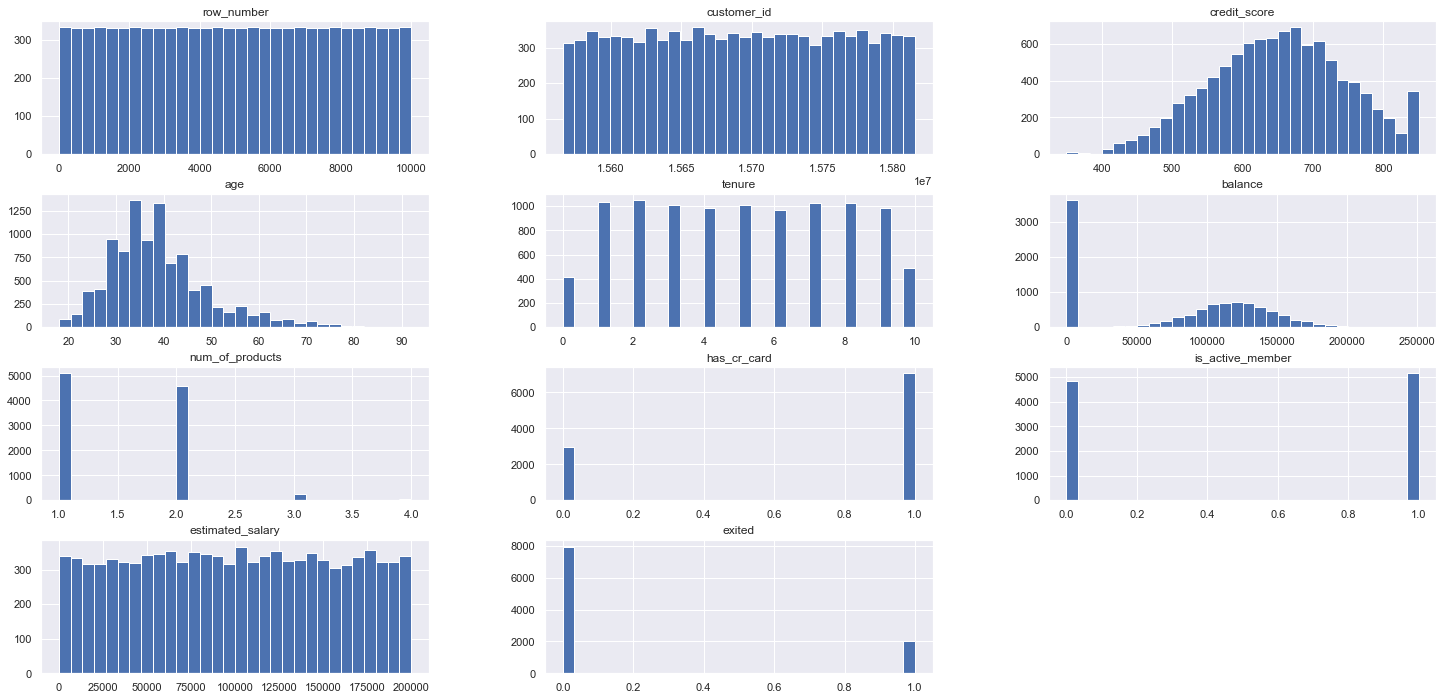

In [21]:
num_analysis(num_attributes)

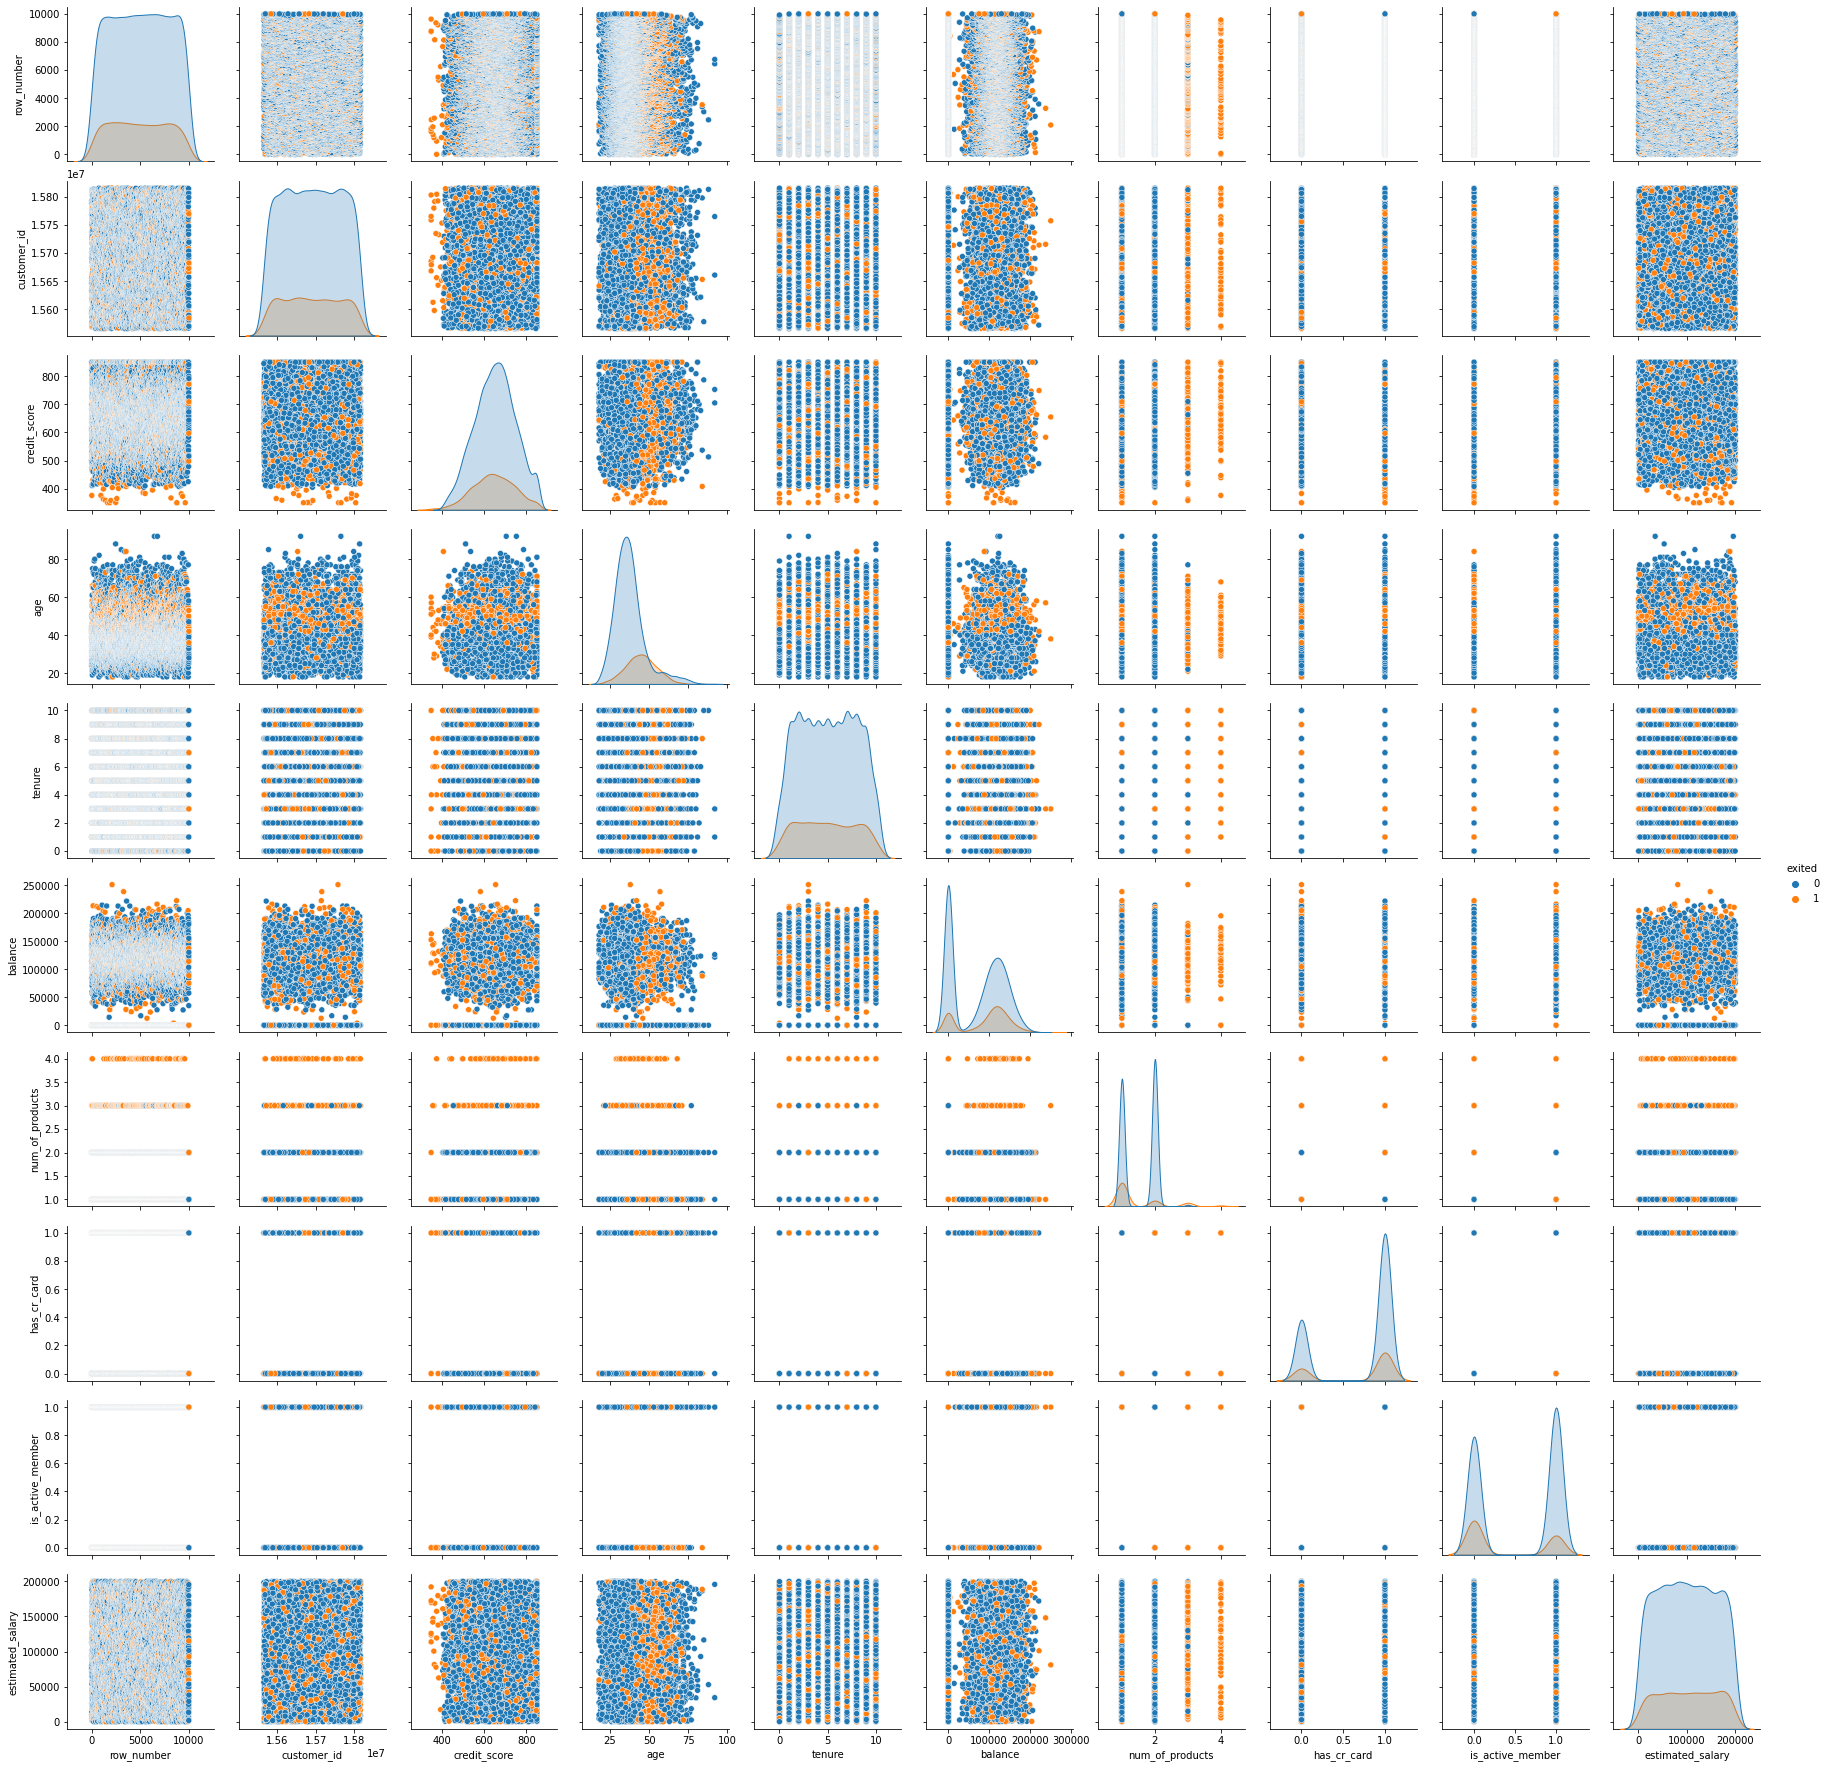

In [19]:
sns.pairplot(num_attributes, hue='exited') # unbalanced 'exited' variable

### 1.5.2. Categorical attributes

In [19]:
cat_attributes.head()

,surname,geography,gender
0,Hargrave,France,Female
1,Hill,Spain,Female
2,Onio,France,Female
3,Boni,France,Female
4,Mitchell,Spain,Female


In [61]:
cat_attributes.apply(lambda x: x.unique().shape)

,surname,geography,gender
0,2932,3,2


In [ ]:
cat_attributes.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='surname,geography,gender'>

In [24]:
aux1 = df1[['geography', 'estimated_salary']].groupby('geography')

In [27]:
aux1.describe()

estimated_salary                                                                                
                     count           mean           std     min       25%        50%        75%        max
geography                                                                                                 
France              5014.0   99899.180814  57336.289016   90.07  51399.19   99132.31  149295.36  199929.17
Germany             2509.0  101113.435102  58263.011501   11.58  51016.02  102397.22  151083.80  199970.74
Spain               2477.0   99440.572281  57103.678091  417.41  50267.69   99984.86  147278.43  199992.48

# 2. Feature Engineering

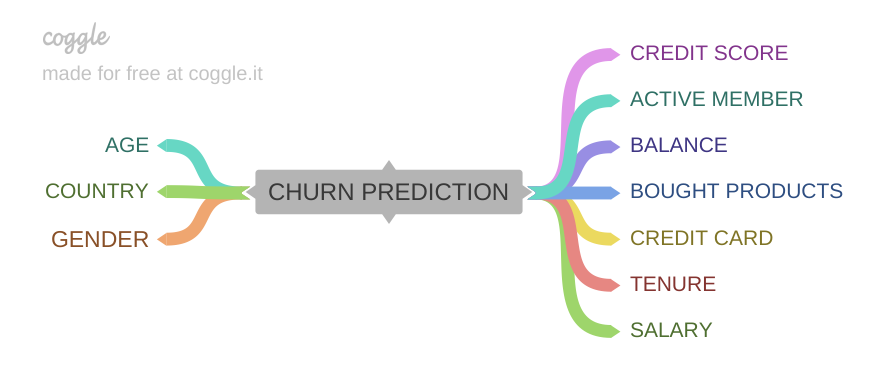

In [86]:
Image('img/CHURN_PREDICTION.png')

### Monetary related data

CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.

Balance: Valor monetário que o cliente tem em sua conta bancária.

NumOfProducts: O número de produtos comprado pelo cliente no banco.

HasCrCard: Indica se o cliente possui ou não cartão de crédito.

IsActiveMember: Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.

EstimateSalary: Estimativa do salário mensal do cliente.

Tenure: Número de anos que o cliente permaneceu ativo.
### Client description

RowNumber: O número da coluna

CustomerID: Identificador único do cliente

Surname: Sobrenome do cliente.

Geography: O país onde o cliente reside.

Gender: O gênero do cliente.

Age: A idade do cliente.

### Response variable

Exited: Indica se o cliente está ou não em Churn.

## Monetary related hypothesis

1. Clients with higher credit score are less likely to churn

2. Clients with higher balance are less likely to churn

3. Clients with higher number of products boght are less likely to churn

4. Clients with a credit card are less likely to churn

5. Clients that are active members are less likely to churn

6. Clients with higher estimatd salaries are less likely to churn

## Descriptive related hypothesis

1. Clients from Spain have higher churn rate

2. Male clients have higher churn rate

3. Older clients have higher churn rte

4. Clients with higher tenura are less likely to churn

In [22]:
df2 = df1.copy()

In [23]:
# geography
# df2['geography'] = df2['geography'].apply(lambda x: 0 if x=='France' else 1 if x=='Spain' else 2)

# gender
df2['gender'] = df2['gender'].apply(lambda x: 0 if x=='Male' else 1)

In [24]:
df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


# 3. Data Filter

In [25]:
df3 = df2.copy()

## 3.1. Rows Filtes

## 3.2. Columns Filter

In [26]:
df3 = df3.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [27]:
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


# 4. EDA

### The three objectives of Exploratory Data Analysis:

**1.** To acquire new business insights.

**2.** Validate previous business insights.

**3.** Perceive variables that are importante in the modelling of the phenomenon in case.

### Types of analysis:

**1.** Univariate: how is the variable distribution (min, max, distribution, range...)

**2.** Bivariate: how does this variable influence the response variable (correlation, hypothesis validation...)

**3.** Multivariate: how do variables correlate to each other?

In [79]:
from ClfAutoEDA import *

### EDA Parameters


Once the module is imported, you can call
EDA function in your python @le which
will automatically do all the required
exploration on your dataset. Before calling
the function we must understand the
function parameters:
EDA(df,labels,target_variable_
name,

data_summary_figsize,corr_matr
ix_figsize,

data_summary_figcol,corr_matri
x_figcol,
 corr_matrix_annot,
 pairplt_col,pairplt,

feature_division_figsize)
df : dataframe containing your
classi@cation data
labels: 1D list of str. (The names given to
the labels of the target variable )
target_variable_name: variable of str.
(The name of the target variable in the
dataset)

data_summary_7gsize: tuple. (The size
of @gure containing data summary),
default: (16,16)

corr_matrix_7gsize: tuple. (The size of
@gure containing correlation matrix),
default: (16,16)

data_summary_7gcol: str. (The color
name of @gure containing data summary),
default: ‘Reds_r’

corr_matrix_7gcol: str. (The color name
of @gure containing correlation matrix),
default: ‘Blues’

corr_matrix_annot: boolean. (True if you
want to display annotations/coeTcients
on the correlation matrix), default: False
pairplt_col: 1D list of str. (The names of
the columns/features for which pairplots
are required), default: ‘all’ (All the
features will be taken)

pairplt: boolean. (True if you want to
pairplots), default: False

feature_division_7gsize: tuple. (The size
of @gure containing bar and pie plot of
proportion of target and categorical
feature labels), default: (12,12)

NOTE- This function returns 3 items
(dataframe after removing null values,
list of numerical features, list of
categorical features) apart from the
EDA plots and data description. The EDA
plots include heatmaps of correlation
matrix, data summary, missing values,
skewness plots, violin plots, pairplots,
boxplots and categorical features’
distribution bar and pie charts.

In [28]:
df4 = df3.copy()

In [29]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


In [30]:
df4[df4['exited']==1].count()

credit_score        2037
geography           2037
gender              2037
age                 2037
tenure              2037
balance             2037
num_of_products     2037
has_cr_card         2037
is_active_member    2037
estimated_salary    2037
exited              2037
dtype: int64

<AxesSubplot:>

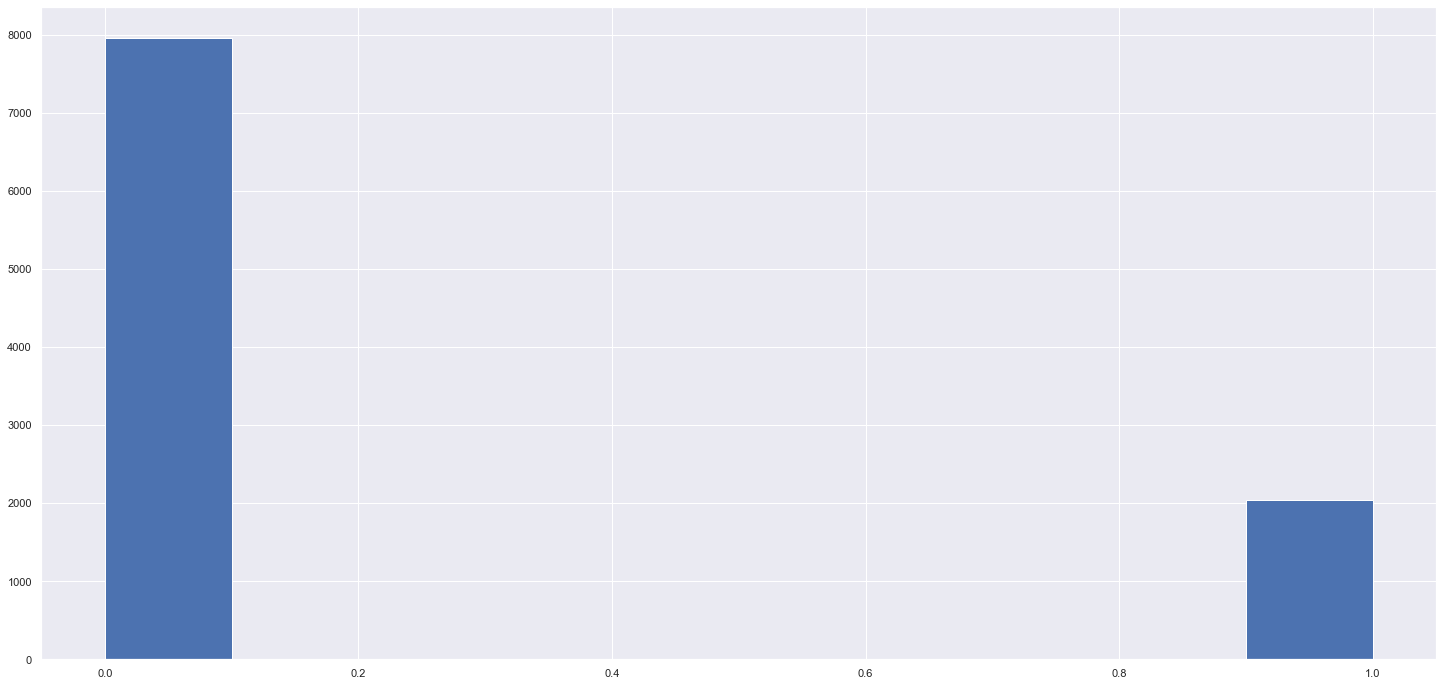

In [33]:
df4['exited'].hist()

# 5. Pre-Modeling

In [31]:
df5 = df4.copy()

## Enconding

In [32]:
df5 = pd.get_dummies(df5, prefix=['geography'], columns=['geography'])

In [33]:
df5

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,0,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,1,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,0,42,3,75075.31,2,1,0,92888.52,1,0,1,0


## 5.1. Balancing Data

In [36]:
df5['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [37]:
# combine.SMOTETomek([sampling_strategy, …])	Class to perform over-sampling using SMOTE and cleaning using Tomek links.

ratio_balanced = {1:7963, 0:7963}

In [38]:
 # define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

In [39]:
# apply sampler
X_smt, y_smt = smt.fit_resample( df5.drop('exited', axis=1), df5['exited'] )

In [40]:
X_smt

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
0,619,1,42,2,0.000000,1,1,1,101348.880000,1,0,0
1,502,1,42,8,159660.800000,3,1,0,113931.570000,1,0,0
2,850,1,43,2,125510.820000,1,1,1,79084.100000,0,0,1
3,645,0,44,8,113755.780000,2,1,0,149756.710000,0,0,1
4,822,0,50,7,0.000000,2,1,1,10062.800000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13639,620,1,45,3,68748.634458,1,1,0,167877.449524,1,0,0
13640,687,0,43,6,78242.151242,1,0,0,34306.536819,0,0,0
13641,645,1,37,6,130185.375172,1,1,1,153791.092122,1,0,0
13642,677,0,46,3,104816.395402,1,0,1,149438.346224,0,1,0


## 5.2. Standardize, Rescale, Transform

### Rescaling
MinMax: distributions without outliers

Robust Scaler: distributions with considerable outliers

c:\users\lucas\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tenure', ylabel='Density'>

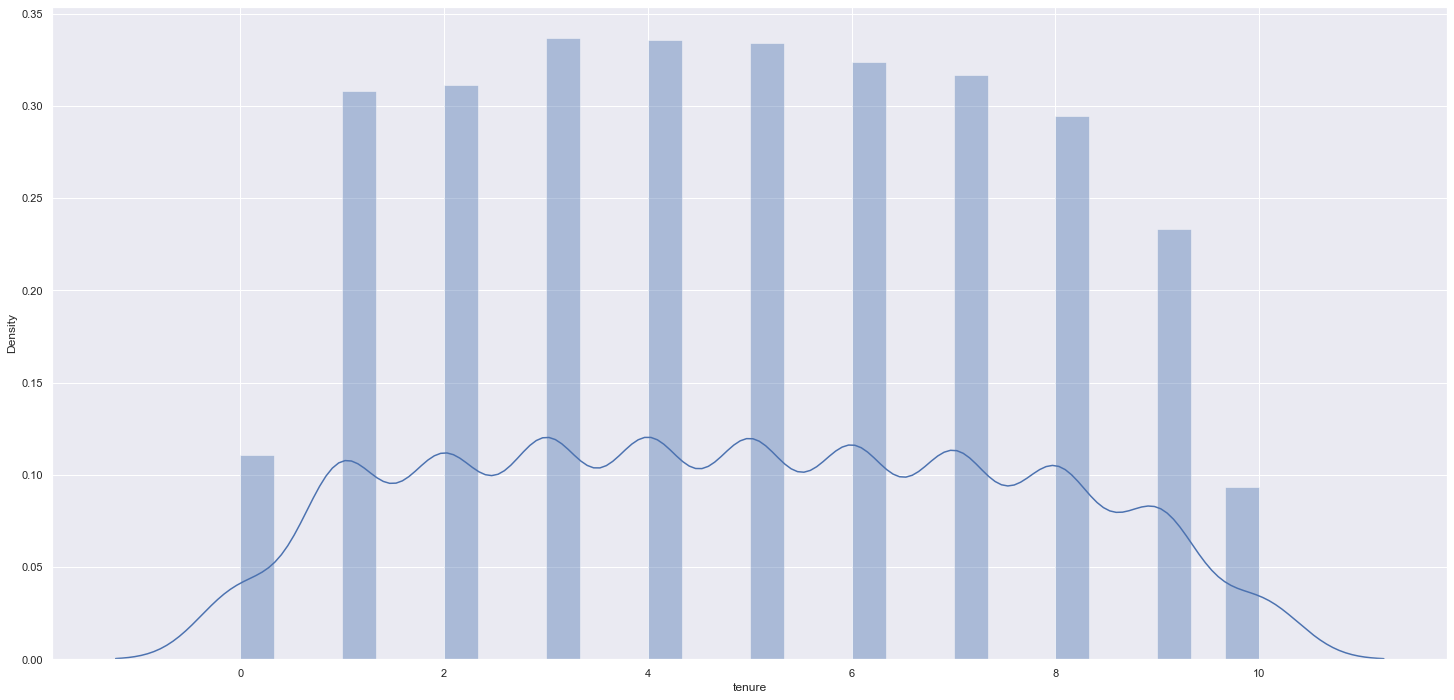

In [114]:
sns.distplot(X_smt['tenure'])

c:\users\lucas\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

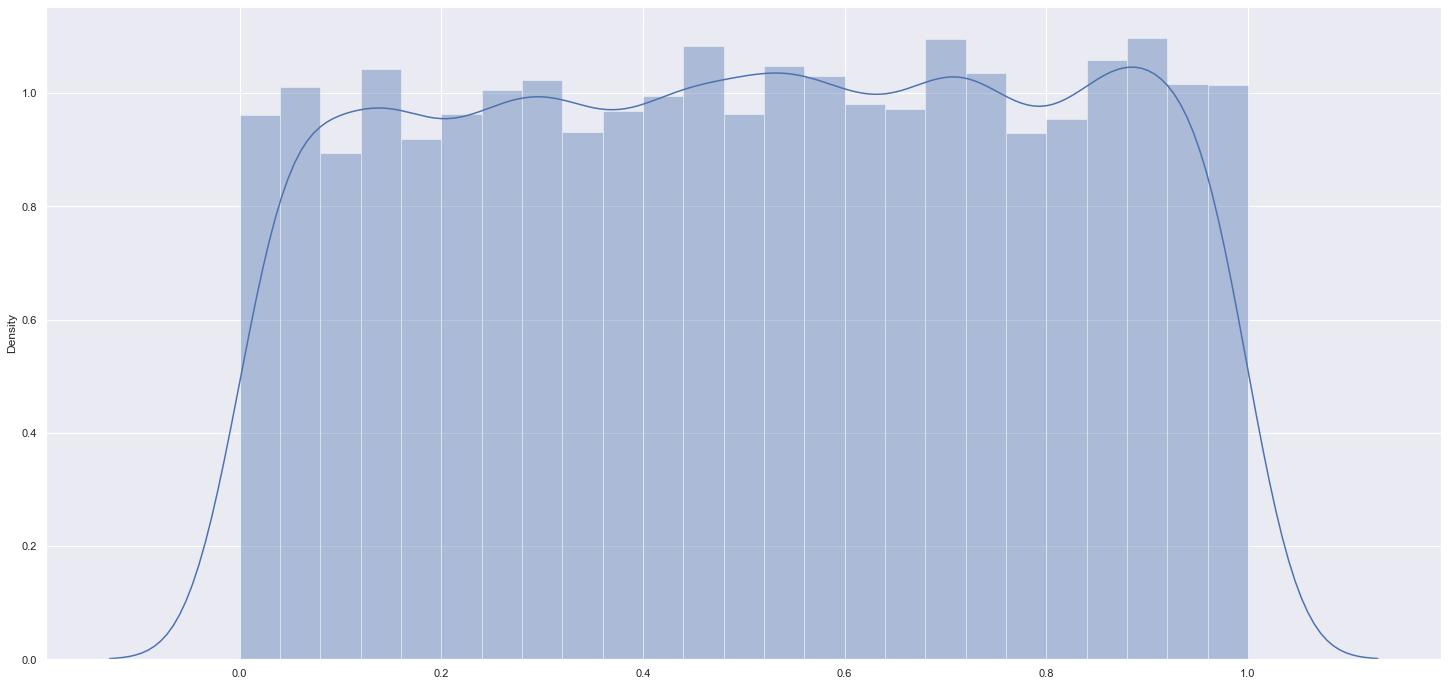

In [103]:
sns.distplot(MinMaxScaler().fit_transform(X_smt['estimated_salary'].values.reshape(-1,1)))

In [41]:
RobustScaler().fit_transform(X_smt['balance'].values.reshape(-1,1))

array([[-0.80480737],
       [ 0.42742064],
       [ 0.16385838],
       ...,
       [ 0.1999356 ],
       [ 0.00414322],
       [-0.47028034]])

In [42]:
# Robust Scaler: balance
X_smt['balance'] = RobustScaler().fit_transform(X_smt['balance'].values.reshape(-1,1))

# MinMax: estimated_salary
X_smt['estimated_salary'] = MinMaxScaler().fit_transform(X_smt['estimated_salary'].values.reshape(-1,1))

# MinMax: estimated_salary
X_smt['tenure'] = MinMaxScaler().fit_transform(X_smt['tenure'].values.reshape(-1,1))

### Normalization

c:\users\lucas\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

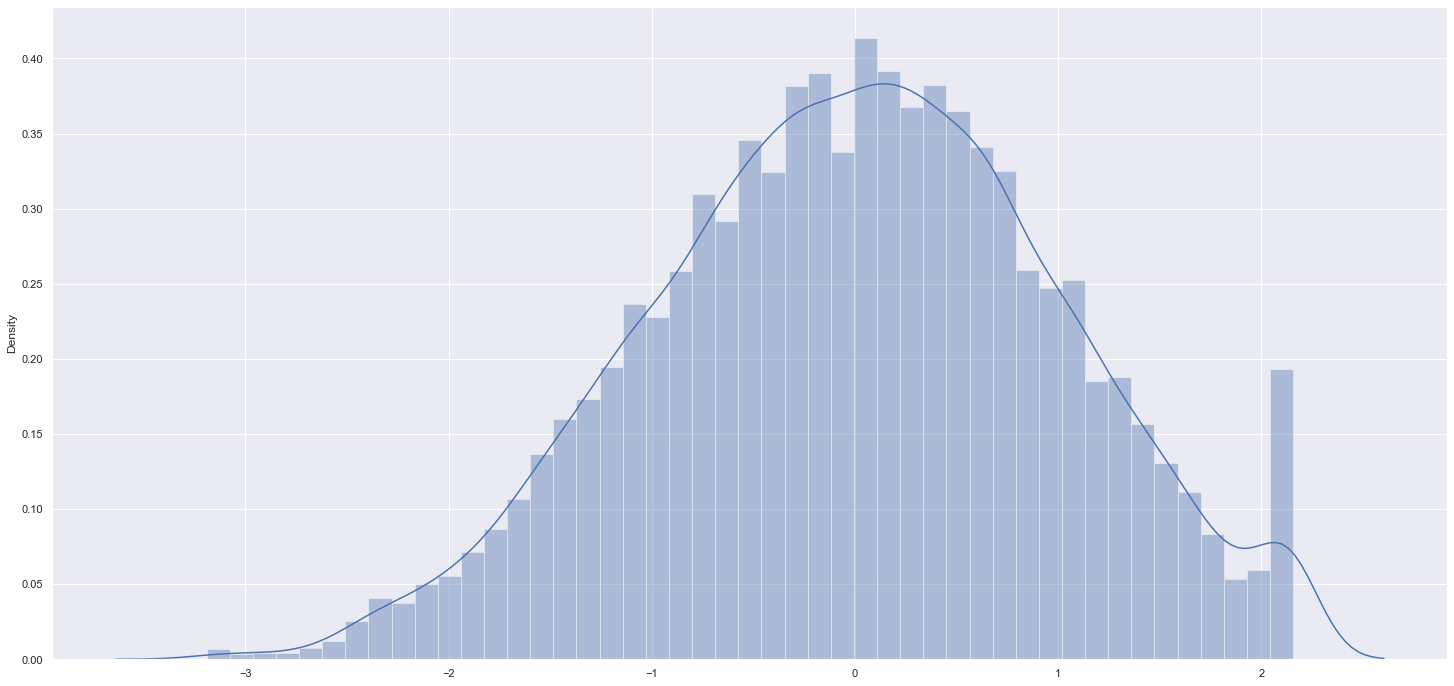

In [111]:
sns.distplot(StandardScaler().fit_transform(X_smt['credit_score'].values.reshape(-1,1)))

In [43]:
# age
X_smt['age'] = StandardScaler().fit_transform(X_smt['age'].values.reshape(-1,1))

# credit_score
X_smt['credit_score'] = StandardScaler().fit_transform(X_smt['credit_score'].values.reshape(-1,1))


In [44]:
X_smt

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
0,-0.313859,1,0.108646,0.2,-0.804807,1,1,1,0.506735,1,0,0
1,-1.565148,1,0.108646,0.8,0.427421,3,1,0,0.569654,1,0,0
2,2.156634,1,0.208990,0.2,0.163858,1,1,1,0.395400,0,0,1
3,-0.035795,0,0.309333,0.8,0.073135,2,1,0,0.748797,0,0,1
4,1.857181,0,0.911392,0.7,-0.804807,2,1,1,0.050261,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13639,-0.303165,1,0.409676,0.3,-0.274220,1,1,0,0.839410,1,0,0
13640,0.413386,0,0.208990,0.6,-0.200951,1,0,0,0.171491,0,0,0
13641,-0.035795,1,-0.393070,0.6,0.199936,1,1,1,0.768971,1,0,0
13642,0.306438,0,0.510019,0.3,0.004143,1,0,1,0.747205,0,1,0


# 6. Feature Selection and Data Split

In [45]:
df6 = pd.concat([X_smt, y_smt], axis=1)
df7 = df6.copy()
df7.head() # no selection needed

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain,exited
0,-0.313859,1,0.108646,0.2,-0.804807,1,1,1,0.506735,1,0,0,1
1,-1.565148,1,0.108646,0.8,0.427421,3,1,0,0.569654,1,0,0,1
2,2.156634,1,0.208990,0.2,0.163858,1,1,1,0.395400,0,0,1,0
3,-0.035795,0,0.309333,0.8,0.073135,2,1,0,0.748797,0,0,1,1
4,1.857181,0,0.911392,0.7,-0.804807,2,1,1,0.050261,1,0,0,0


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.3, random_state=42)

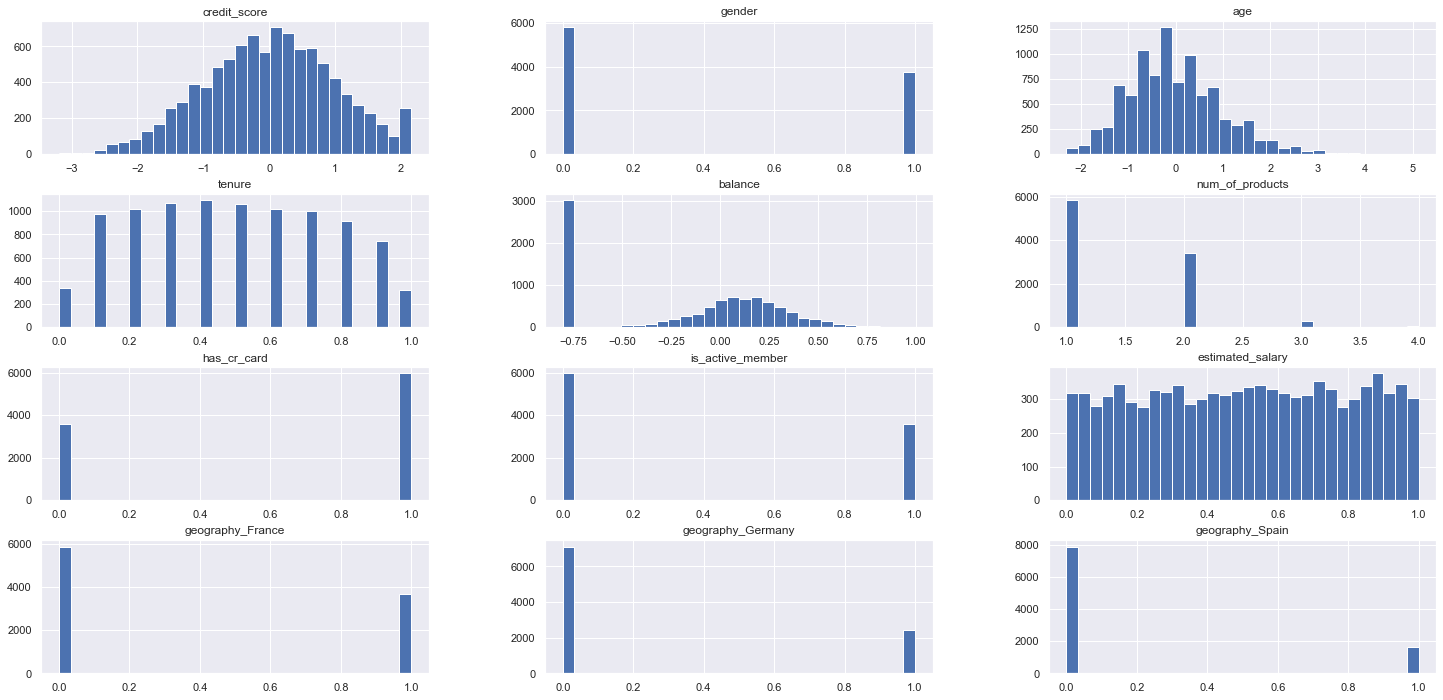

In [47]:
X_train.hist(bins=30);

# 7. ML Models

## Dummy Classifier

In [48]:
# Dummie
dmm = DummyClassifier(strategy='most_frequent')

In [49]:
performance(dmm, X_train, y_train)

c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
c:\users\lucas\miniconda3\

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.501466,0.0,0.0,0.0,0.5,0.0


## Adaboost Classifier

In [50]:
ab = AdaBoostClassifier()

In [51]:
performance(ab, X_train, y_train)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.842618,0.852018,0.828192,0.83983,0.842578,0.685633


## KNeighborsClassifier

In [52]:
error_rate = []

# will take some time:
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

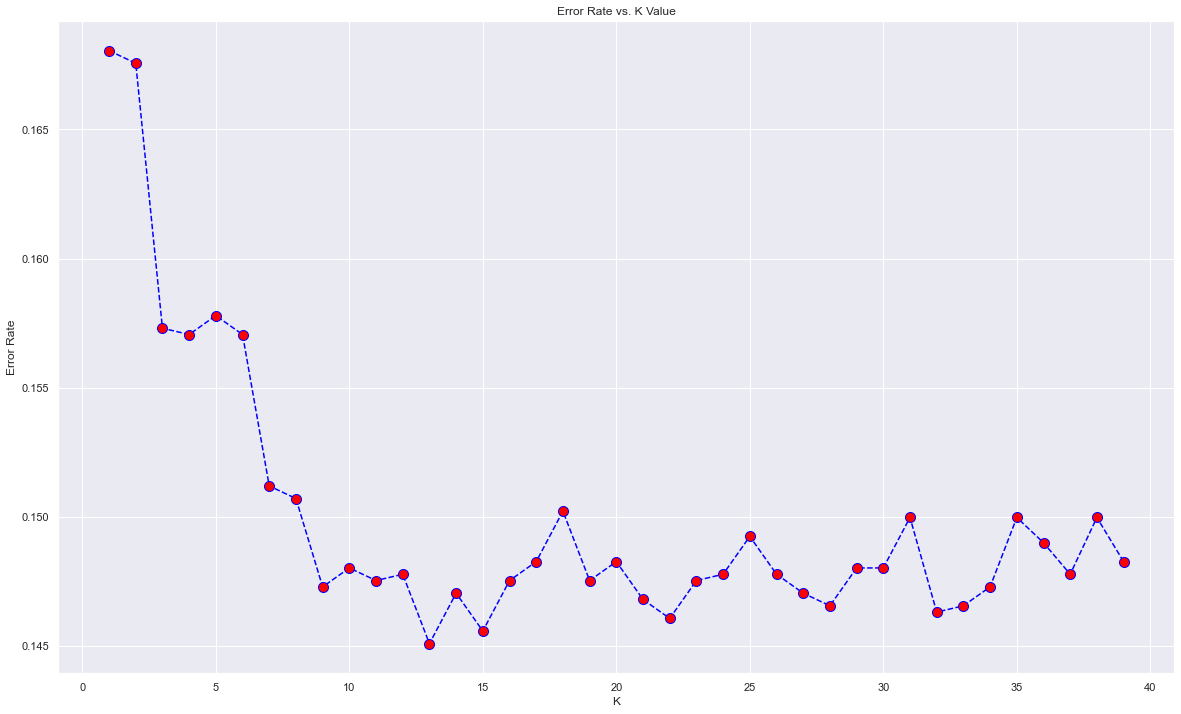

In [53]:
plt.figure(figsize=(20,12))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', 
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [54]:
knc = KNeighborsClassifier(n_neighbors=13)
x = performance(knc, X_train, y_train)
x

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.835812,0.857125,0.804878,0.830028,0.835724,0.673007


# SVM Classifier

In [55]:
svc = SVC()

In [56]:
performance(svc, X_train, y_train)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.854346,0.900245,0.796056,0.844814,0.854178,0.713506


## RandomForestClassifier

In [57]:
rfc = RandomForestClassifier()

In [58]:
performance(rfc, X_train, y_train)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.873508,0.890068,0.851504,0.87027,0.873444,0.747812


## XGBClassifier

In [59]:
xgb = XGBClassifier()

In [60]:
performance(xgb, X_train, y_train)

c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\lucas\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.87267,0.882856,0.858646,0.87047,0.87263,0.74577


# 8. Hyperparameter Fine Tuning

# 9. Error Interpretation

# 10. Model Deploy